# Nuclei Segmentation using StarDist

Credits for this notebook go to Nuclei Segmentation using StarDist tutorial provided by squidpy (https://squidpy.readthedocs.io/en/stable/external_tutorials/tutorial_stardist.html). The first section: "Cell Segmentation on H&E Stained Tissue Data" is entirely based on Squidpy's tutorial.

In [ ]:
# Import the StarDist 2D segmentation models.
from stardist.models import StarDist2D
# Import the recommended normalization technique for stardist.
from csbdeep.utils import normalize

import json
import squidpy as sq
import numpy as np
import matplotlib.pyplot as plt
import sys

### Read Config

In [ ]:
config_path = '../config/config.json'
with open(config_path, "r") as cnf:
    config = json.load(cnf)

In [2]:
StarDist2D.from_pretrained()

There are 4 registered models for 'StarDist2D':

Name                  Alias(es)
────                  ─────────
'2D_versatile_fluo'   'Versatile (fluorescent nuclei)'
'2D_versatile_he'     'Versatile (H&E nuclei)'
'2D_paper_dsb2018'    'DSB 2018 (from StarDist 2D paper)'
'2D_demo'             None


## Cell Segmentation on H&E Stained Tissue Data

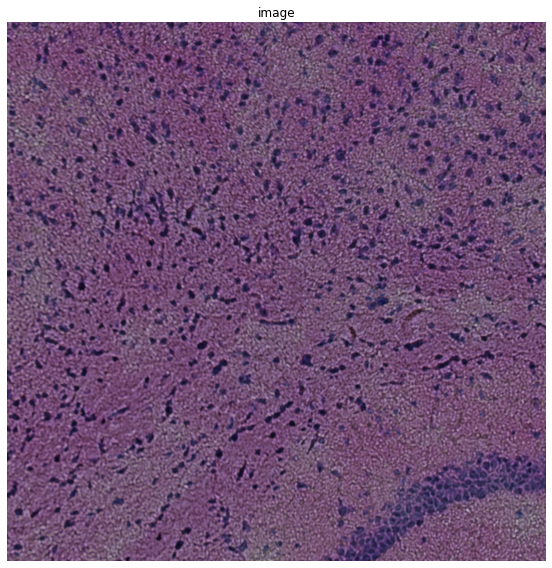

In [5]:
# load H&E stained tissue image and crop to a smaller segment
img = sq.datasets.visium_hne_image_crop()
crop = img.crop_corner(0, 0, size=1000)
crop.show("image")

In [9]:
def stardist_2D_versatile_he(img, nms_thresh=None, prob_thresh=None):
    #axis_norm = (0,1)   # normalize channels independently
    axis_norm = (0,1,2) # normalize channels jointly
    # Make sure to normalize the input image beforehand or supply a normalizer to the prediction function.
    # this is the default normalizer noted in StarDist examples.
    img = normalize(img, 1, 99.8, axis=axis_norm)
    model = StarDist2D.from_pretrained('2D_versatile_he')
    labels, _ = model.predict_instances(img, nms_thresh=nms_thresh, prob_thresh=prob_thresh)
    return labels

In [10]:
StarDist2D.from_pretrained('2D_versatile_he')

Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


StarDist2D(2D_versatile_he): YXC → YXC
├─ Directory: None
└─ Config2D(axes='YXC', backbone='unet', grid=(2, 2), n_channel_in=3, n_channel_out=33, n_classes=None, n_dim=2, n_rays=32, net_conv_after_unet=128, net_input_shape=[None, None, 3], net_mask_shape=[None, None, 1], train_background_reg=0.0001, train_batch_size=8, train_checkpoint='weights_best.h5', train_checkpoint_epoch='weights_now.h5', train_checkpoint_last='weights_last.h5', train_class_weights=(1, 1), train_completion_crop=32, train_dist_loss='mae', train_epochs=200, train_foreground_only=0.9, train_learning_rate=0.0003, train_loss_weights=[1, 0.1], train_n_val_patches=3, train_patch_size=[512, 512], train_reduce_lr={'factor': 0.5, 'patience': 50, 'min_delta': 0}, train_sample_cache=True, train_shape_completion=False, train_steps_per_epoch=200, train_tensorboard=True, unet_activation='relu', unet_batch_norm=False, unet_dropout=0.0, unet_kernel_size=[3, 3], unet_last_activation='relu', unet_n_conv_per_depth=2, unet_n_depth=3,

In [8]:
sq.im.segment(
    img=crop,
    layer="image",
    channel=None,
    method=stardist_2D_versatile_he,
    layer_added='segmented_stardist',
    prob_thresh=0.3,
    nms_thresh=None
)

Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


ImageContainer[shape=(1000, 1000), layers=['image', 'segmented_stardist']]
Number of segments in crop: 632


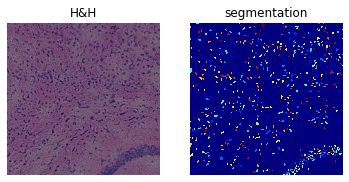

In [9]:
print(crop)
print(f"Number of segments in crop: {len(np.unique(crop['segmented_stardist']))}")

fig, axes = plt.subplots(1, 2)
crop.show("image", ax=axes[0])
_ = axes[0].set_title("H&H")
crop.show("segmented_stardist", cmap="jet", interpolation="none", ax=axes[1])
_ = axes[1].set_title("segmentation")

## Apply StarDist on a sample patch

In [10]:
import h5py
import os

In [11]:
PATH_TO_PROCESSED_DATA = config["processed"]
PATH_TO_TMA_PATCHES = os.path.join(PATH_TO_PROCESSED_DATA, "tma_patches")
PATH_TO_TMA_1 = os.path.join(PATH_TO_TMA_PATCHES, "tma6b.hdf5")

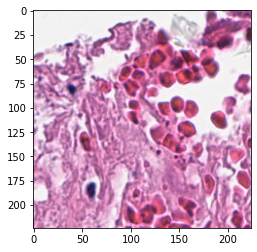

In [14]:
with h5py.File(PATH_TO_TMA_1, "r") as f:
    img_data = f['E0147_v1']
    sample_img = img_data[()][0]
    plt.imshow(sample_img)
    img = sq.im.ImageContainer(sample_img, layer="img1")

In [15]:
sq.im.segment(
    img=img,
    layer="img1",
    channel=None,
    method=stardist_2D_versatile_he,
    layer_added='segmented_stardist',
    prob_thresh=0.3,
    nms_thresh=None
)

Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


ImageContainer[shape=(224, 224), layers=['img1', 'segmented_stardist']]
Number of segments in crop: 21


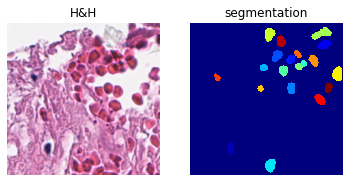

In [16]:
print(img)
print(f"Number of segments in crop: {len(np.unique(img['segmented_stardist']))}")

fig, axes = plt.subplots(1, 2)
img.show("img1", ax=axes[0])
_ = axes[0].set_title("H&H")
img.show("segmented_stardist", cmap="jet", interpolation="none", ax=axes[1])
_ = axes[1].set_title("segmentation")

## Apply StarDist on a sample TMA core

In [3]:
import numpy as np
import os
from PIL import Image

In [4]:
PATH_TO_TMA_CORES = os.path.join(PATH_TO_PROCESSED_DATA, "cores")
PATH_TO_SAMPLE_CORE = os.path.join(PATH_TO_TMA_CORES, "tma_1_E0046 B_v1.tif")

In [5]:
im = Image.open(PATH_TO_SAMPLE_CORE)

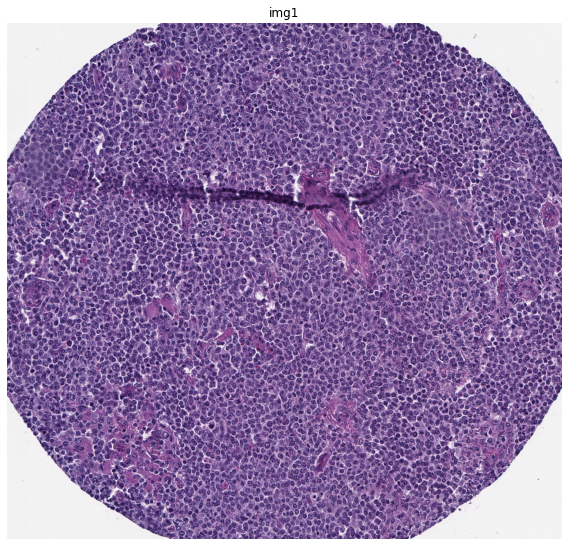

In [6]:
img = sq.im.ImageContainer(np.array(im), layer="img1")
img.show("img1")

In [11]:
sq.im.segment(
    img=img,
    layer="img1",
    channel=None,
    method=stardist_2D_versatile_he,
    layer_added='segmented_stardist',
    prob_thresh=0.3,
    nms_thresh=None
)

Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


ImageContainer[shape=(2296, 2468), layers=['img1', 'segmented_stardist']]
Number of segments in crop: 7196


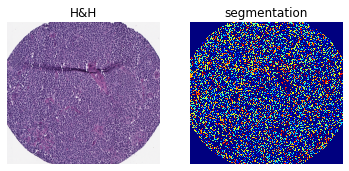

In [12]:
print(img)
print(f"Number of segments in crop: {len(np.unique(img['segmented_stardist']))}")

fig, axes = plt.subplots(1, 2)
img.show("img1", ax=axes[0])
_ = axes[0].set_title("H&H")
img.show("segmented_stardist", cmap="jet", interpolation="none", ax=axes[1])
_ = axes[1].set_title("segmentation")

### View StarDist Segmentation output

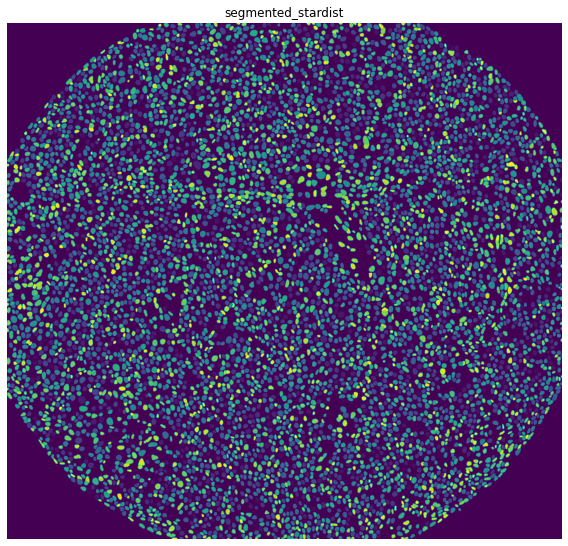

In [13]:
img.show("segmented_stardist")

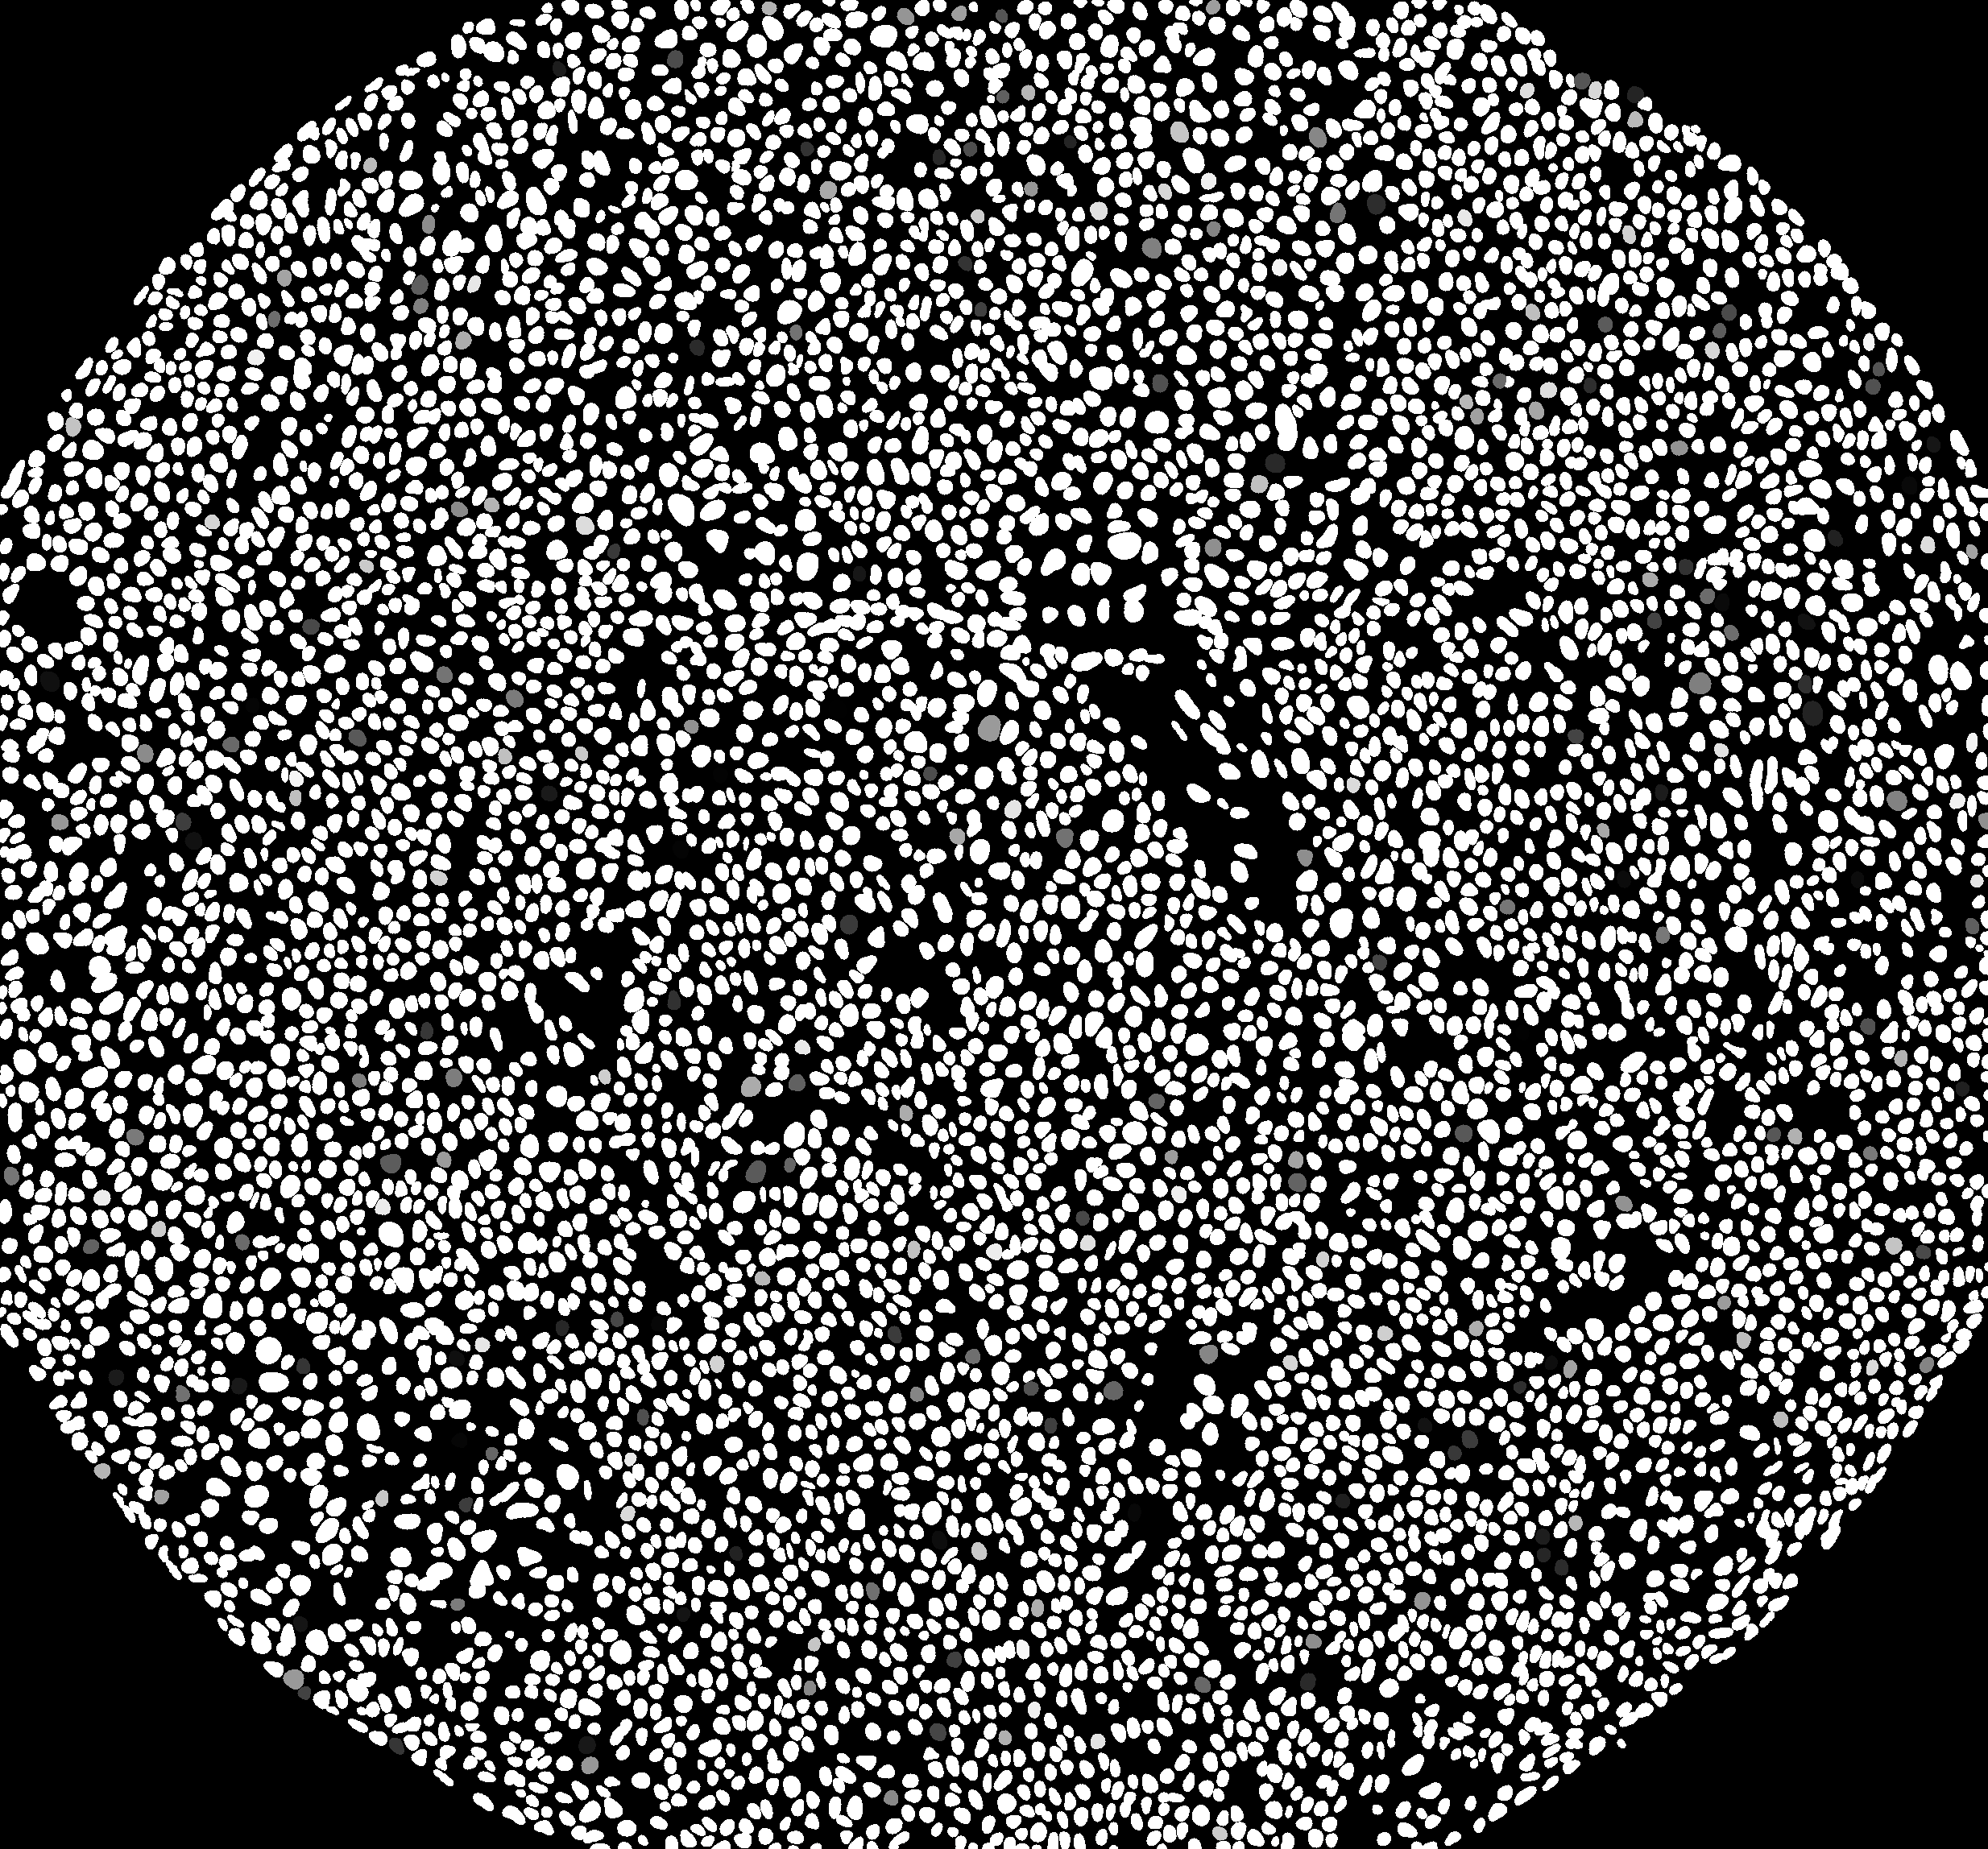

In [14]:
segmented_npy = np.squeeze(img['segmented_stardist'].data).copy()
Image.fromarray(segmented_npy).convert("L")